## Limpe seus dados

In [9]:
library(data.table)
library(forecast)
library(zoo)

### Lidando com dados ausente

Dados ausentes em séries temporais são bastantes comuns visto que a carga de amostragem longitudinal é bastante pesada. Dessa forma, se desenvolveu metodos para lidar com dados ausente em series temporais no quais são:

1. Imputação
2. Interpolação
3. Exclusão dos tempos afetados

#### Preparação

Vamos gerar conjunto de dados contendo dados nulos, usando a taxa de desemprego dos estados unidos. Removendo aleatoriamente os dados e removendo o mesmo com maior indice de desemprego

In [2]:
unrate = fread('dataset/UNRATE.csv')
head(x = unrate, n = 5)

DATE,UNRATE
<IDate>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [3]:
unrate[, DATE:= as.Date(DATE)]
setkey(unrate, DATE)

In [4]:
# Gerando um conjunto de dados onde estão aleatoriamente ausentes
set.seed(1)
rand.unrate.idx = sample(1:nrow(x = unrate), .1*nrow(unrate))
rand.unrate.idx

[1] 836 679 129 509 471 299 270 187 307 597 277 494 330 775 591 725  37 105 729
[20] 485 677 802 382 601 801 326 832 554 422 111 404 532 506 556 343 582 121  40
[39] 684 537 375 248 198 378  39 435 390 280 672 526 642  45 402  22 718 742 193
[58] 371 499 104 819 767 492 616 615 465 525 826 176 345 110  84  29 141 252 733
[77] 620 304 545 557 661 287 614 145

In [5]:
rand.unrate = unrate[-rand.unrate.idx]

In [6]:
# Removendo dados com maior prob de NA quando o desempredo é alto

high.unrate.idx = which(unrate$UNRATE > 8)
num.to.select   = .2 * length(high.unrate.idx)

high.unrate.idx = sample(high.unrate.idx, )

bias.unrate = unrate[-high.unrate.idx]

In [7]:
all.date = seq(from = unrate$DATE[1], to = tail(x = unrate$DATE, n = 1), by = 'month')


rand.unrate = rand.unrate[J(all.date), roll=0]
bias.unrate = bias.unrate[J(all.date), roll=0]

rand.unrate[, rpt:=is.na(UNRATE)]

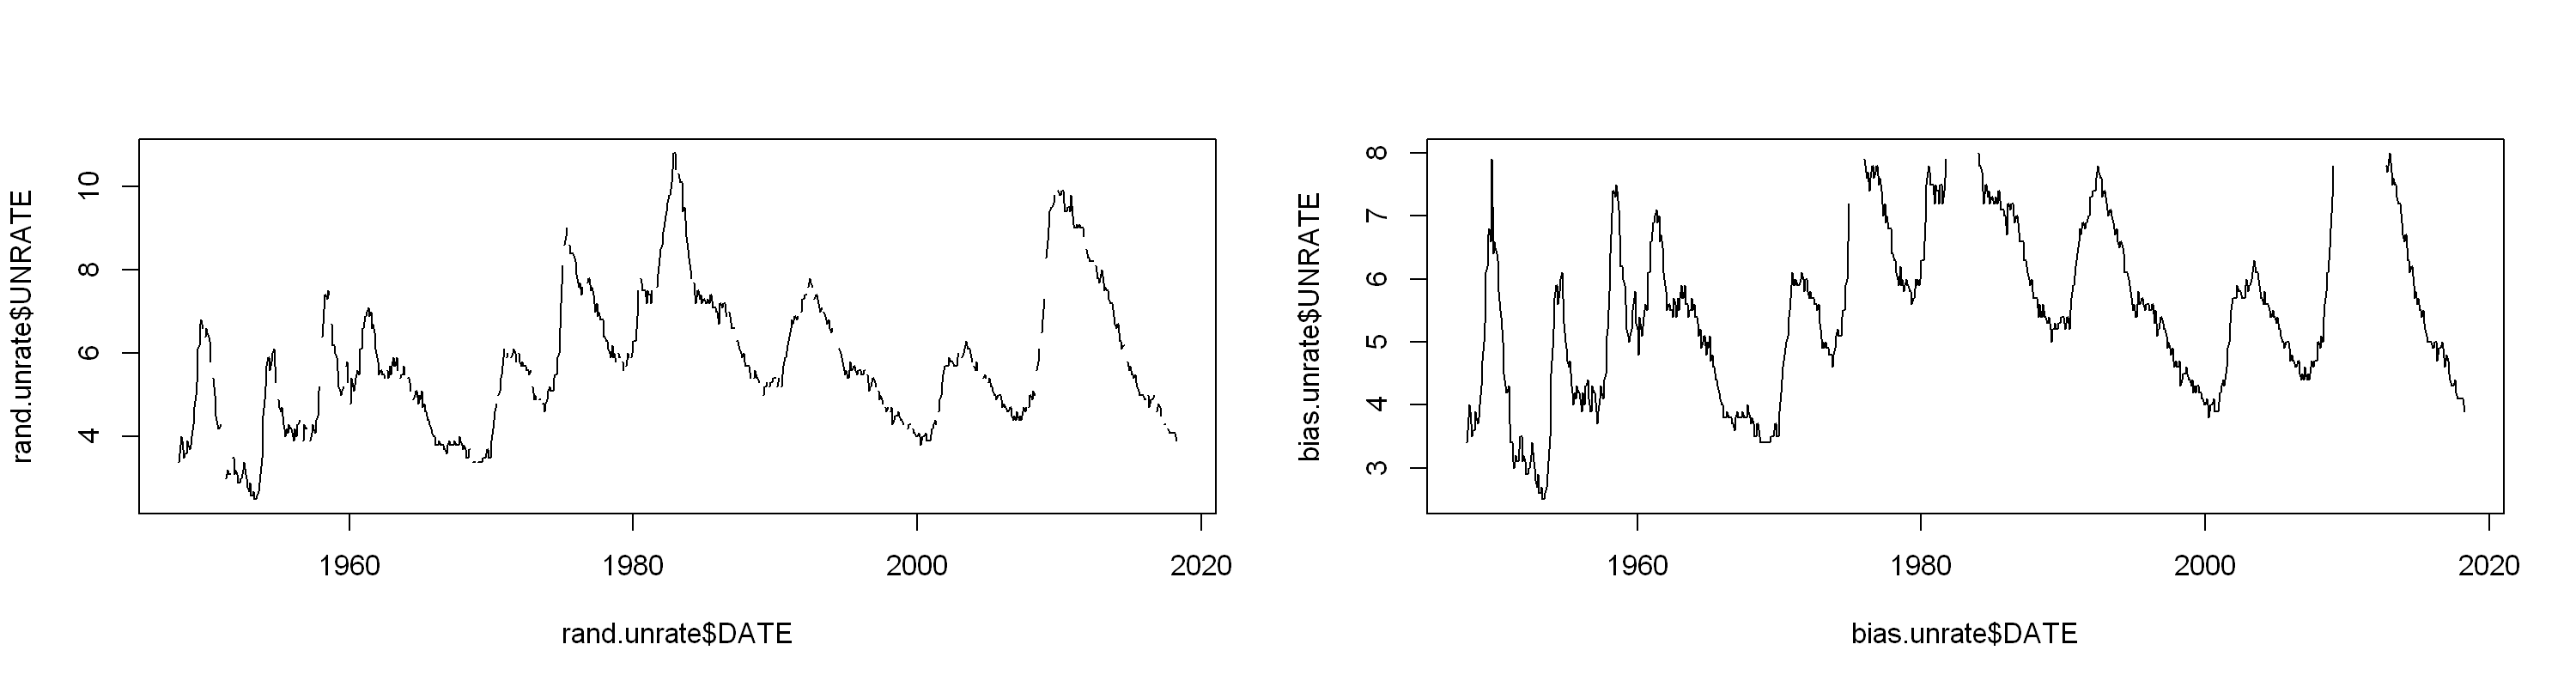

In [8]:
par(mfrow = c(1, 2), bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
plot(rand.unrate$DATE, rand.unrate$UNRATE, type = 'l')
plot(bias.unrate$DATE, bias.unrate$UNRATE, type = 'l')

### Métodos de imputação

#### Foward fill
Uma das formas mais simples de preencher os valores ausente é transferindo o ultimo valor conhecido para o valor ausente anterior

In [44]:
rand.unrate[, imputacao.ff := na.locf(UNRATE)]
bias.unrate[, imputacao.ff := na.locf(UNRATE)]

NULL

NULL

NULL

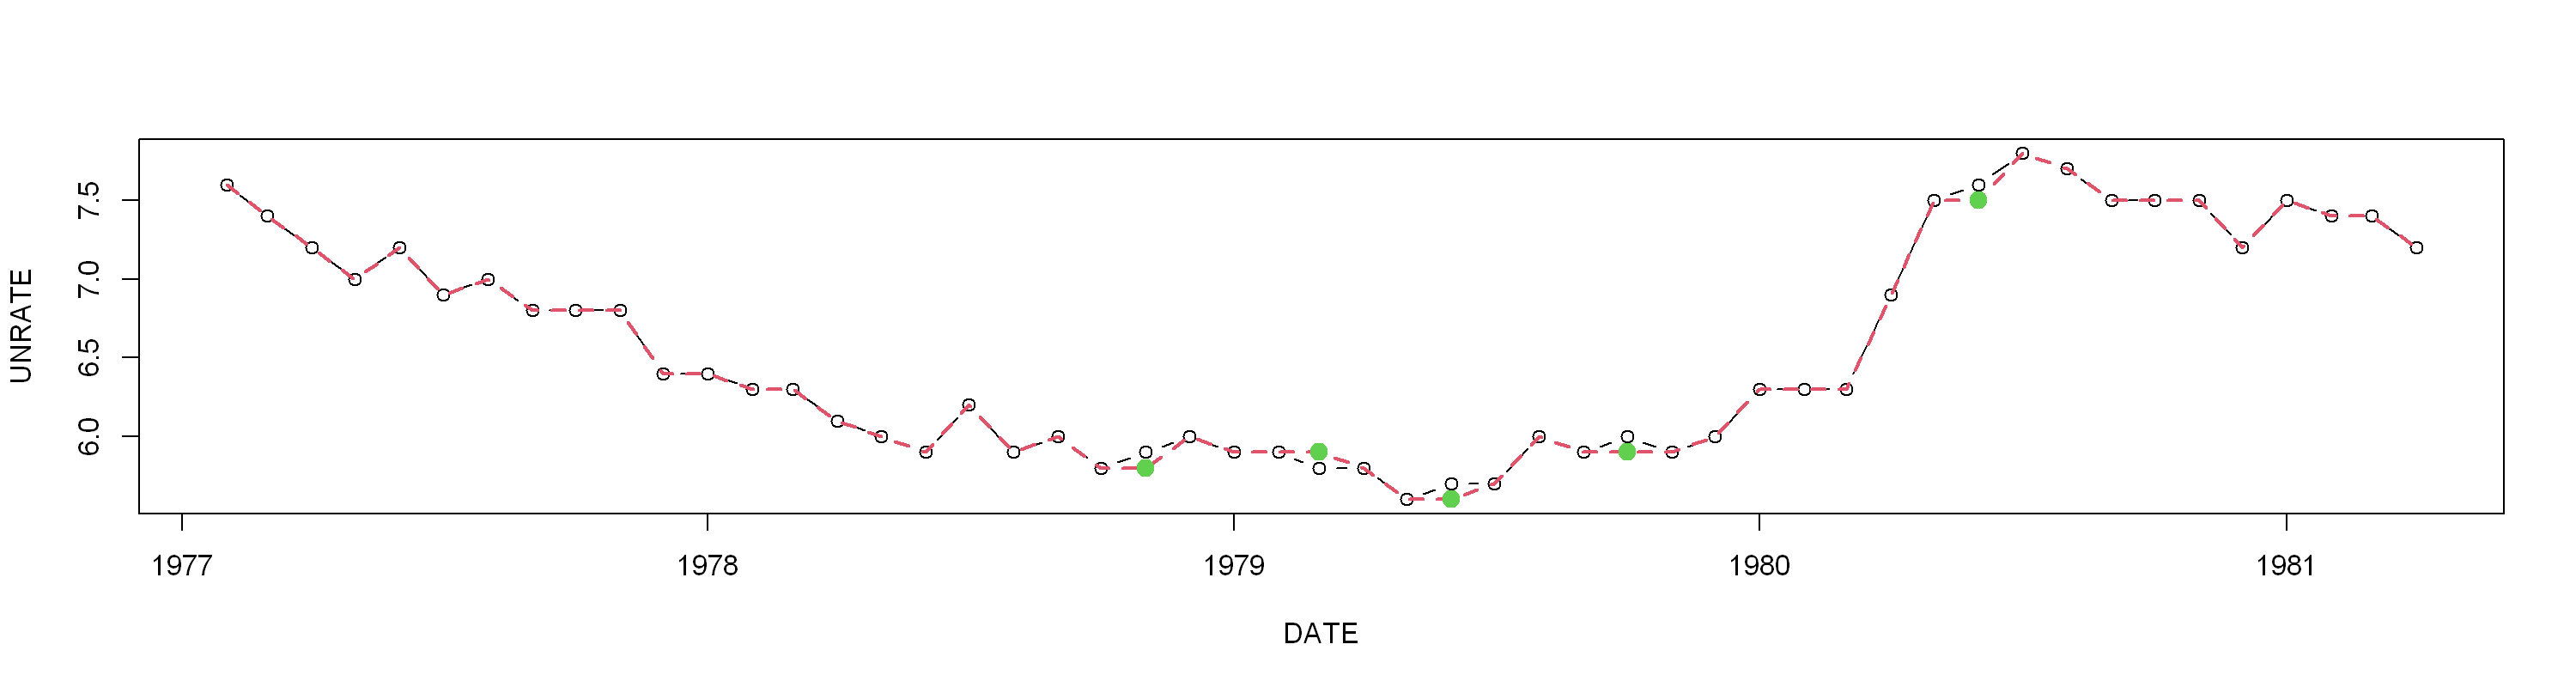

In [45]:
par(bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
unrate[350:400,
    plot(DATE, UNRATE, type = 'b', lwd=1, col=1),
]
rand.unrate[350:400,
    lines(DATE, imputacao.ff, col=2, lwd=2, lty=2)
]
rand.unrate[
    350:400
][rpt==TRUE, points(DATE, imputacao.ff, col=3, pch=20, cex=2)]


> Os pontos ventes são os valores imputados

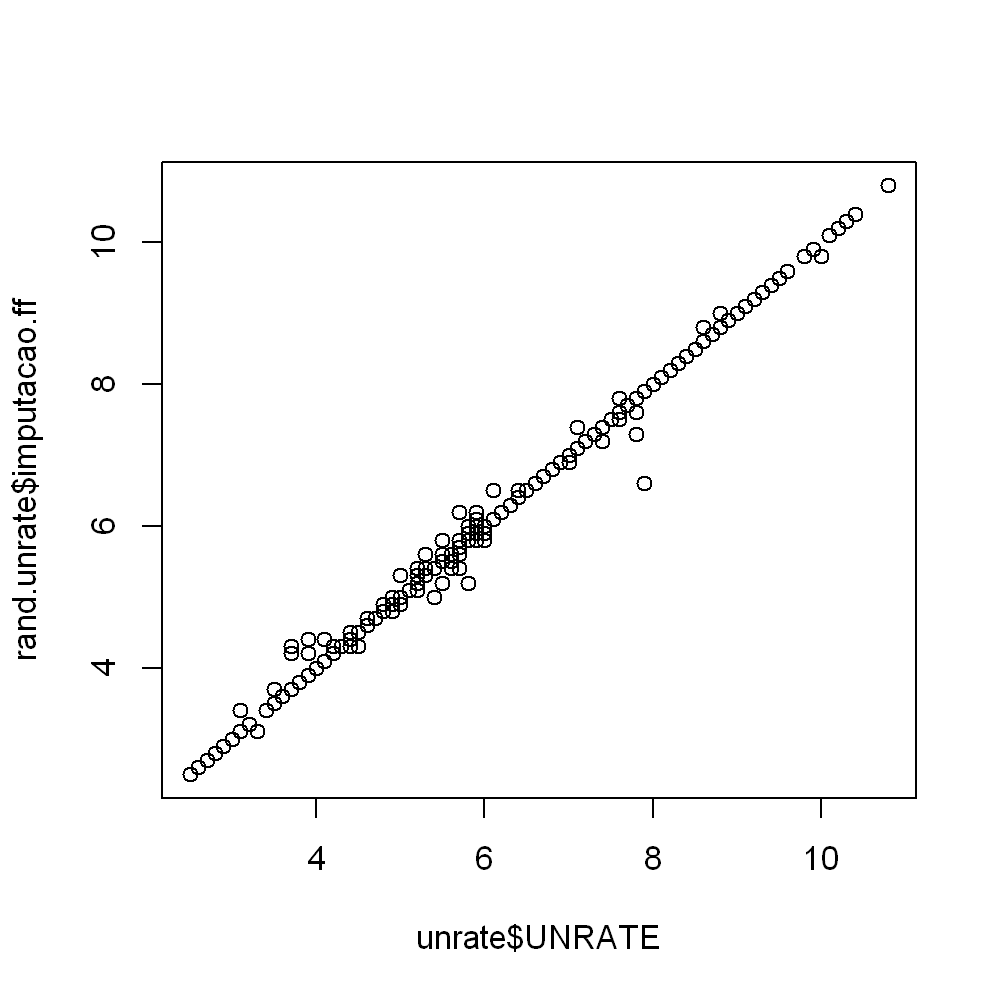

In [46]:
par(bg = 'white')
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plot(unrate$UNRATE, rand.unrate$imputacao.ff)

> Voce pode usar o forward fill para pegar valores do passados e progeta-los no futoro mas isso é o **lookhead**
> #### LOOKHEAD
> Lookahead bias é quando, sem querer, você usa dados de períodos futuros para treinar ou validar um modelo para períodos > passados.
>
> Exemplo: ao calcular a média móvel de janeiro usando dados de fevereiro, você está “espiando” o futuro
>
> **SO USE SE NÃO QUISER TREINAR UM MODELO**

> **Foward fill** apresenta muitas vantagem: não é computacionamente caro e apresentea um desempenho decente em relação a imputação

#### Média Movel
